In [1]:
import pandas as pd
import s3fs
import numpy as np

In [2]:
fs = s3fs.S3FileSystem(client_kwargs={"endpoint_url": "https://minio.lab.sspcloud.fr"})
MY_BUCKET = "williamolivier"

FILE_PATH_S3_FVDEP = f"{MY_BUCKET}/diffusion/epci_6_clusters.csv"
with fs.open(FILE_PATH_S3_FVDEP, "rb") as file:
    epci_features = pd.read_csv(file)


In [3]:
# CALCUL EMISSIONS TOTALES 

pollution_au_km_flux_jaunes ={
    "Bus": 0.092, 
    "Métro/tram/transilien": 0.0045,
    "TER": 0.02693
}

pollution_au_km_flux_rouges = 0.144

# Dictionnaire avec les valeurs choisies pour chaque mode de TC en % de la distance parcourue en TC 

flux_jaunes_detail = {
    0 : { #Villes moyennes
        "Métro/tram/transilien": 0.2,
        "TER": 0.4,   
        "Bus": 0.4   
    },
    1 : { #Banlieue Paris
        "Métro/tram/transilien": 0.7,  
        "TER": 0.1,    
        "Bus": 0.2    
    },
    2 : { #Paris
        "Métro/tram/transilien": 0.8,  
        "TER": 0.1,   
        "Bus": 0.1   
    },
    3 : { #Autres
        "Métro/tram/transilien": 0, 
        "TER": 0.5,    
        "Bus": 0.5     
    },
    4 : { #Grandes villes
        "Métro/tram/transilien" : 0.5,
        "TER" : 0.2,
        "Bus" : 0.3
    },
    5 : { # Banlieue proche Paris
        "Métro/tram/transilien" : 0.7,
        "TER" : 0.1,
        "Bus" : 0.2
    }
}


# ici flux intra + moyenne des flux sortants et entrants 
epci_features["moyenne_flux_rouges"] = (
    epci_features['distance_intra_rouge'] +(
    epci_features['distance_entrant_<10km_rouge'] + 
    epci_features['distance_entrant_10<x<20km_rouge'] + 
    epci_features['distance_entrant_20<x<30km_rouge']  +
    epci_features['distance_entrant_30<x<40km_rouge'] + 
    epci_features['distance_entrant_40<x<50km_rouge']+ 
    epci_features['distance_entrant_50<x<infkm_rouge']  + 
    epci_features['distance_sortant_<10km_rouge']  + 
    epci_features['distance_sortant_10<x<20km_rouge']  + 
    epci_features['distance_sortant_20<x<30km_rouge'] +
    epci_features['distance_sortant_30<x<40km_rouge']+ 
    epci_features['distance_sortant_40<x<50km_rouge']+ 
    epci_features['distance_sortant_50<x<infkm_rouge'])/2)
    

epci_features['pollution_flux_rouges'] = epci_features['moyenne_flux_rouges'] * pollution_au_km_flux_rouges

epci_features["moyenne_flux_jaunes"] = (
    epci_features['distance_intra_jaune']+ (
    epci_features['distance_entrant_<10km_jaune']+ 
    epci_features['distance_entrant_10<x<20km_jaune'] + 
    epci_features['distance_entrant_20<x<30km_jaune'] +
    epci_features['distance_entrant_30<x<40km_jaune'] + 
    epci_features['distance_entrant_40<x<50km_jaune'] + 
    epci_features['distance_entrant_50<x<infkm_jaune'] + 
    epci_features['distance_sortant_<10km_jaune'] + 
    epci_features['distance_sortant_10<x<20km_jaune']  + 
    epci_features['distance_sortant_20<x<30km_jaune']+
    epci_features['distance_sortant_30<x<40km_jaune'] + 
    epci_features['distance_sortant_40<x<50km_jaune'] + 
    epci_features['distance_sortant_50<x<infkm_jaune'])/2)


for transport in ['Métro/tram/transilien', 'TER', 'Bus']:
    # Appliquer la répartition pour chaque mode de transport en fonction du cluster
    epci_features[f'distance_{transport}'] = epci_features['moyenne_flux_jaunes'] * \
        epci_features['cluster'].map(lambda cluster: flux_jaunes_detail.get(cluster, {}).get(transport, 0))

for transport in ['Métro/tram/transilien', 'TER', 'Bus']:
    # Calculer la pollution en multipliant la distance par les émissions par km pour chaque mode
    epci_features[f'pollution_{transport}'] = epci_features[f'distance_{transport}'] * pollution_au_km_flux_jaunes[transport]

epci_features['pollution_flux_jaunes'] = (
    epci_features['pollution_Métro/tram/transilien'] + epci_features['pollution_TER'] + 
    epci_features['pollution_Bus']) 

epci_features['pollution_totale'] = (
    epci_features['pollution_flux_rouges'] + epci_features['pollution_flux_jaunes'])


In [4]:
mauvais_eleves = []

for cluster_id in epci_features['cluster'].unique():
    # On sélectionne les lignes du cluster
    groupe = epci_features[epci_features['cluster'] == cluster_id]
    seuil = groupe['pollution_flux_rouges'].mean() + 2*groupe['pollution_flux_rouges'].std()
    mauvais = groupe[groupe['pollution_flux_rouges'] > seuil]
    mauvais_eleves.append(mauvais)

# On concatène tous les mauvais élèves en un seul DataFrame
mauvais_eleves_par_cluster = pd.concat(mauvais_eleves)

In [23]:
print(100*6000/epci_features.iloc[262]['pollution_flux_rouges'])
print(100*6000/epci_features.iloc[270]['pollution_flux_rouges'])

1.3635363002352994
1.3981311894582216


In [5]:
print(len(mauvais_eleves[0]))
print(len(mauvais_eleves[1]))
print(len(mauvais_eleves[2]))
print(len(mauvais_eleves[3]))
print(len(mauvais_eleves[4]))
print(len(mauvais_eleves[5]))
print(mauvais_eleves_par_cluster['NOM'])

13
4
0
0
1
1
245    ['Sempy', 'Beaurainville', 'Noyelles-lès-Humiè...
366    ['Videcosville', 'Pierreville', 'Gatteville-le...
472    ['Montreuil-sur-Mer', 'Camiers', 'Étaples', 'B...
549    ['Embres-et-Castelmaure', 'Fontjoncouse', 'Fit...
601    ['Aubigny', 'Gannay-sur-Loire', 'Bresnay', 'Pa...
689    ['Boucieu-le-Roi', 'Glun', 'Saint-Victor', "Po...
758    ['Gruissan', 'Leucate', 'Port-la-Nouvelle', 'G...
831    ['Saint-Pabu', 'Coat-Méal', 'Landéda', 'Le Dre...
840    ['Landivisiau', 'Bodilis', 'Commana', 'Saint-V...
841    ['Névez', 'Trégunc', 'Concarneau', 'Tourch', '...
842    ['Trégarantec', 'Guissény', 'Kerlouan', 'Le Fo...
844    ['Locquirec', 'Guerlesquin', 'Botsorhel', 'Loc...
882    ['Saint-Caprais-de-Bordeaux', 'Langoiran', 'Le...
45     ['Saint-Laurent-de-la-Salanque', 'Saint-Nazair...
830    ['Guipavas', 'Plouzané', 'Le Relecq-Kerhuon', ...
836    ['Rédené', 'Clohars-Carnoët', 'Saint-Thurien',...
843    ['Daoulas', 'Loperhet', 'Logonna-Daoulas', 'Sa...
262    ['Puteaux',

In [6]:
# cluster 1
print(mauvais_eleves_par_cluster['NOM'][270])

# cluster 4
print(mauvais_eleves_par_cluster['NOM'][262])

# cluster 1
print(mauvais_eleves_par_cluster['NOM'][45])
print(mauvais_eleves_par_cluster['NOM'][830])
print(mauvais_eleves_par_cluster['NOM'][836])
print(mauvais_eleves_par_cluster['NOM'][843])

# cluster 3
print(mauvais_eleves_par_cluster['NOM'][245])
print(mauvais_eleves_par_cluster['NOM'][366])
print(mauvais_eleves_par_cluster['NOM'][472])
print(mauvais_eleves_par_cluster['NOM'][549])
print(mauvais_eleves_par_cluster['NOM'][601])
print(mauvais_eleves_par_cluster['NOM'][689])
print(mauvais_eleves_par_cluster['NOM'][758])
print(mauvais_eleves_par_cluster['NOM'][831])
print(mauvais_eleves_par_cluster['NOM'][840])
print(mauvais_eleves_par_cluster['NOM'][841])
print(mauvais_eleves_par_cluster['NOM'][842])
print(mauvais_eleves_par_cluster['NOM'][844])
print(mauvais_eleves_par_cluster['NOM'][882])

['Claye-Souilly', 'Chennevières-lès-Louvres', 'Le Thillay', 'Villiers-le-Bel', 'Villeron', 'Puiseux-en-France', 'Épiais-lès-Louvres', 'Moussy-le-Neuf', 'Saint-Mard', 'Fontenay-en-Parisis', 'Le Mesnil-Aubry', 'Vémars', 'Fosses', 'Gonesse', 'Bonneuil-en-France', 'Villeneuve-sous-Dammartin', 'Louvres', 'Survilliers', 'Longperrier', 'Le Plessis-Gassot', 'Marly-la-Ville', 'Dammartin-en-Goële', 'Saint-Witz', 'Thieux', 'Bouqueval', 'Garges-lès-Gonesse', 'Moussy-le-Vieux', 'Goussainville', 'Rouvres', 'Arnouville', 'Compans', 'Gressy', 'Écouen', 'Juilly', 'Othis', 'Vaudherland', 'Le Mesnil-Amelot', 'Villeparisis', 'Mauregard', 'Mitry-Mory', 'Sarcelles', 'Roissy-en-France']
['Puteaux', 'Nanterre', 'Vaucresson', 'Saint-Cloud', 'Neuilly-sur-Seine', 'Courbevoie', 'La Garenne-Colombes', 'Rueil-Malmaison', 'Garches', 'Levallois-Perret', 'Suresnes']
['Saint-Laurent-de-la-Salanque', 'Saint-Nazaire', 'Pézilla-la-Rivière', "Espira-de-l'Agly", 'Canet-en-Roussillon', 'Le Barcarès', 'Sainte-Marie-la-Mer', '

In [7]:
mauvais_eleves_par_cluster['cluster']

245    3
366    3
472    3
549    3
601    3
689    3
758    3
831    3
840    3
841    3
842    3
844    3
882    3
45     0
830    0
836    0
843    0
262    5
270    1
Name: cluster, dtype: int64

In [8]:
# Le code ne s'exécute pas ici

# print(plot_pollution_par_cluster(mauvais_eleves_par_cluster, cluster_id=3))
# print(plot_pollution_par_cluster(mauvais_eleves_par_cluster, cluster_id=0))
# print(plot_pollution_par_cluster(mauvais_eleves_par_cluster, cluster_id=5))
# print(plot_pollution_par_cluster(mauvais_eleves_par_cluster, cluster_id=1))

## Simulations politiques de décarbonation 

In [9]:
# Scénario 1 : Electrification des véhicules 

# Hypothèse d'électrification possible par cluster
part_electrique_dict = {
    0: 0.3,  # Villes moyennes
    1: 0.4,  # Banlieue Paris
    2: 0.6,  # Paris
    3: 0.2,  # Autres / ruraux
    4: 0.4,  # Grandes villes
    5: 0.5   # Banlieue proche Paris
}

def scenario_electrification_par_cluster(df, part_electrique_dict, facteur_thermique=0.097, facteur_electrique=0.02):
    df = df.copy()

    def get_facteur_moyen(cluster):
        part_elec = part_electrique_dict.get(cluster, 0)
        return part_elec * facteur_electrique + (1 - part_elec) * facteur_thermique

    # Appliquer le facteur d'émission moyen par cluster
    df['facteur_moyen'] = df['cluster'].apply(get_facteur_moyen)

    # Calcul des émissions simulées
    df['pollution_flux_rouges_simu'] = df['moyenne_flux_rouges'] * df['facteur_moyen']
    df['pollution_totale_simu'] = df['pollution_flux_rouges_simu'] + df['pollution_flux_jaunes']
    df['gain_kg_CO2'] = df['pollution_totale'] - df['pollution_totale_simu']
    df['pollution_flux_jaunes_simu'] = df['pollution_flux_jaunes'] # les flux jaunes ne changent pas ici

    
    return df

df_simu_elec = scenario_electrification_par_cluster(mauvais_eleves_par_cluster, part_electrique_dict)

In [10]:
# Scénario 2 : Report partiel sur les transports en commun (création de nouvelles lignes, augmentation fréquence,etc)

def scenario_report_vers_TC(df, part_reportee=0.2):
    df = df.copy()

    # Distance transférée de la voiture vers le TC
    distance_reportee = df['moyenne_flux_rouges'] * part_reportee
    df['moyenne_flux_rouges_simu'] = df['moyenne_flux_rouges'] * (1 - part_reportee)

    # Nouvelle pollution des flux rouges (voiture)
    df['pollution_flux_rouges_simu'] = df['moyenne_flux_rouges_simu'] * pollution_au_km_flux_rouges

    # Pollution ajoutée côté TC
    for transport in ['Métro/tram/transilien', 'TER', 'Bus']:
        part_transport = df['cluster'].map(lambda cluster : flux_jaunes_detail.get(cluster, {}).get(transport, 0))
        df[f'distance_{transport}_ajoutee'] = distance_reportee * part_transport
        df[f'pollution_{transport}_ajoutee'] = df[f'distance_{transport}_ajoutee'] * pollution_au_km_flux_jaunes[transport]

    # Nouvelle pollution totale des flux jaunes
    df['pollution_flux_jaunes_simu'] = (
        df['pollution_flux_jaunes'] +
        df['pollution_Métro/tram/transilien_ajoutee'] +
        df['pollution_TER_ajoutee'] +
        df['pollution_Bus_ajoutee']
    )

    # Recalcul total
    df['pollution_totale_simu'] = df['pollution_flux_rouges_simu'] + df['pollution_flux_jaunes_simu']
    df['gain_kg_CO2'] = df['pollution_totale'] - df['pollution_totale_simu']

    return df

df_simu_report_TC = scenario_report_vers_TC(mauvais_eleves_par_cluster, part_reportee=0.2)

In [11]:
# Droite gains différents taux de report vers TC 

# 🔁 Liste des taux de report
parts_reportees = [i / 100 for i in range(5, 51, 5)]

# 📊 Stocker les résultats
resultats = []

for part in parts_reportees:
    df_simu = scenario_report_vers_TC(mauvais_eleves_par_cluster, part_reportee=part)
    gain_total = df_simu['gain_kg_CO2'].sum() / 1e3  # En tonnes
    resultats.append(gain_total)

# 📈 Tracé du graphique
plt.figure(figsize=(10, 6))
plt.plot([p * 100 for p in parts_reportees], resultats, marker='o', color='green')
plt.title("Gain total de CO₂ évité en fonction de la part reportée vers les TC")
plt.xlabel("Part du report vers TC (%)")
plt.ylabel("Gain total en CO₂ (tonnes)")
plt.grid(True)
plt.tight_layout()
plt.show()


NameError: name 'plt' is not defined

In [ ]:
# Visualisation graphique des gains réalisés par un scénario 
def plot_repartition_flux_avant_apres(df, label_col='SIREN_EPCI', titre_scenario="scénario"):
    import numpy as np
    import matplotlib.pyplot as plt

    df = df.copy()

    for col in ['pollution_flux_rouges', 'pollution_flux_rouges_simu', 
                'pollution_flux_jaunes', 'pollution_flux_jaunes_simu', 'cluster', 'gain_kg_CO2']:
        if col not in df.columns:
            raise ValueError(f"Colonne manquante : {col}")

    gain_total_tonnes = df['gain_kg_CO2'].sum() / 1e3
    print(f"Gain total estimé : {gain_total_tonnes:.2f} tonnes de CO₂ évitées")

    noms = df[label_col].astype(str) + " (" + df['cluster'].astype(str) + ")"
    x = np.arange(len(df))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, max(6, len(df) * 0.4)))
    
    ax.bar(x - width/2, df['pollution_flux_rouges'], width, label='Flux rouges – Avant', color='#d73027')
    ax.bar(x - width/2, df['pollution_flux_jaunes'], width, 
           bottom=df['pollution_flux_rouges'], label='Flux jaunes – Avant', color='#fee08b')

    ax.bar(x + width/2, df['pollution_flux_rouges_simu'], width, label='Flux rouges – Après', color='#a50026')
    ax.bar(x + width/2, df['pollution_flux_jaunes_simu'], width, 
           bottom=df['pollution_flux_rouges_simu'], label='Flux jaunes – Après', color='#d9ef8b')
    
    ax.set_ylabel("Émissions de CO₂ (kg)")
    ax.set_title(f"Répartition des émissions – {titre_scenario}")
    ax.set_xticks(x)
    ax.set_xticklabels(noms, rotation=45, ha='right')
    ax.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

Gain total estimé : 5017.98 tonnes de CO₂ évitées


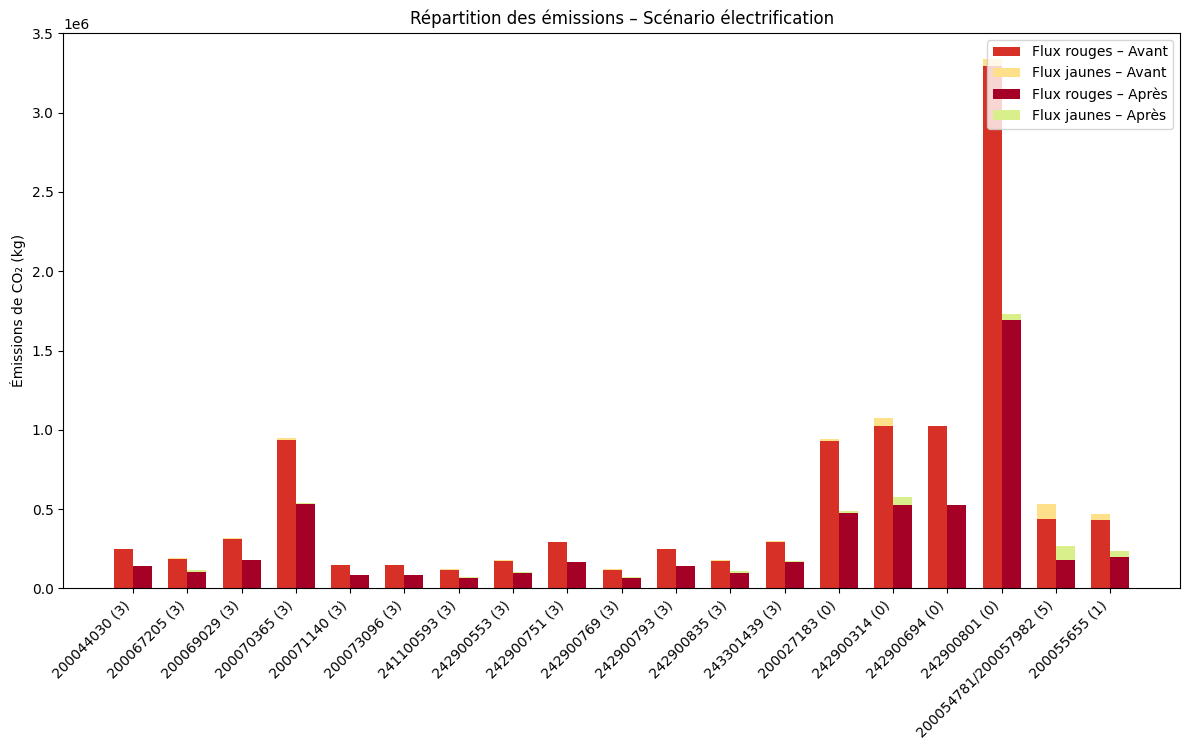

In [ ]:
plot_repartition_flux_avant_apres(df_simu_elec, label_col='SIREN_EPCI', titre_scenario='Scénario électrification')

Gain total estimé : 1375.45 tonnes de CO₂ évitées


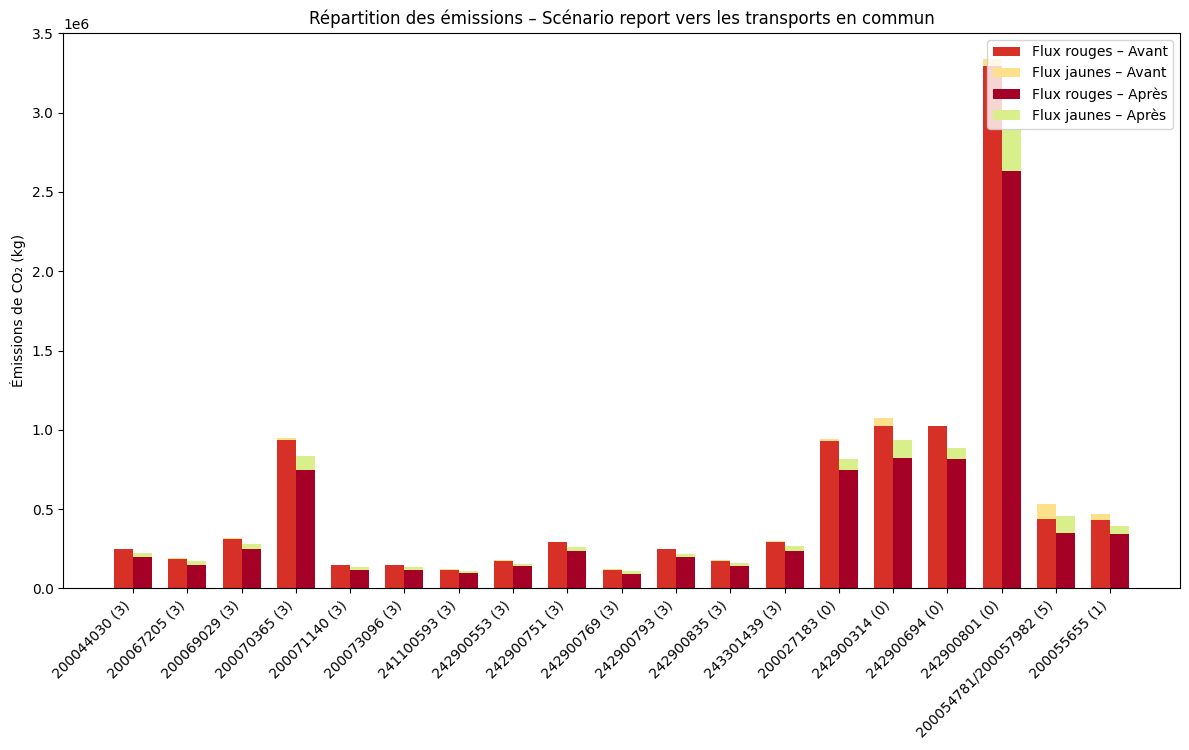

In [ ]:
plot_repartition_flux_avant_apres(df_simu_report_TC, label_col='SIREN_EPCI', titre_scenario='Scénario report vers les transports en commun')

Gain total estimé : 1789.04 tonnes de CO₂ évitées


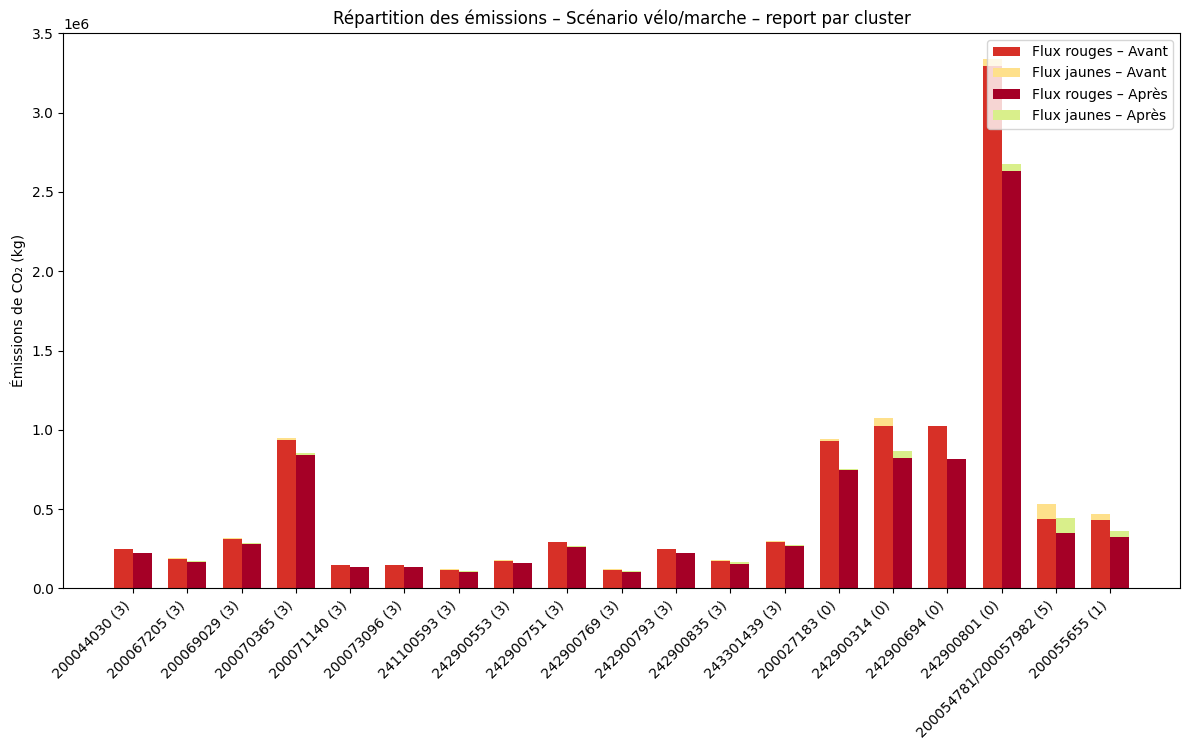

In [ ]:
part_reportee_dict = {
    0: 0.20,  # Villes moyennes
    1: 0.25,  # Banlieue Paris
    2: 0.20,  # Paris
    3: 0.10,  # Autres / ruraux
    4: 0.15,  # Grandes villes
    5: 0.20   # Banlieue proche Paris
}

def scenario_report_velo_marche_par_cluster(df, part_reportee_dict):
    """
    Simule un scénario où une part des trajets en voiture est remplacée par la marche ou le vélo (pollution = 0),
    avec un taux de report variable selon le cluster.
    """
    df = df.copy()

    # Appliquer le taux de report selon le cluster
    df['part_reportee'] = df['cluster'].map(part_reportee_dict).fillna(0)

    # Mise à jour des flux rouges
    df['moyenne_flux_rouges_simu'] = df['moyenne_flux_rouges'] * (1 - df['part_reportee'])
    df['pollution_flux_rouges_simu'] = df['moyenne_flux_rouges_simu'] * pollution_au_km_flux_rouges

    # Flux jaunes ne changent pas
    df['pollution_flux_jaunes_simu'] = df['pollution_flux_jaunes']

    # Pollution totale simulée
    df['pollution_totale_simu'] = df['pollution_flux_rouges_simu'] + df['pollution_flux_jaunes_simu']
    df['gain_kg_CO2'] = df['pollution_totale'] - df['pollution_totale_simu']

    return df

df_simu_velo_marche_clusters = scenario_report_velo_marche_par_cluster(mauvais_eleves_par_cluster, part_reportee_dict)

plot_repartition_flux_avant_apres(
    df_simu_velo_marche_clusters,
    label_col='SIREN_EPCI',
    titre_scenario="Scénario vélo/marche – report par cluster"
)
